# Transfer Learning for Computer Vision
Training classifier on CIFAR dataset.

In [136]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")
from tqdm.notebook import tqdm, trange
from typing import List
from collections import Counter
import cv2

In [200]:
# Transforms
def resize(img):
    return cv2.resize(img.numpy(), dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    
def permute(img):
    return img.permute(1, 2, 0)

def permute_back(img):
    return img.permute(2, 0, 1)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        permute,
        resize,
        transforms.ToTensor()
    ]
)

# Built-in dataset (the same as Kaggle)
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                       download=True, transform=transform)

train_size = int(0.8 * len(dataset))  # 40_000
test_size = len(dataset) - train_size  # 10_000
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Trainloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=12,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [228]:
def imshow(tensor, ax=None):
    size = np.prod(tensor.shape)
    height = width = int((size // 3)**0.5)
    # permuting, because we want rgb channels as third dimension (not first)
    image = tensor.view(3, width, height)
    image = image.permute(1, 2, 0)
    if ax:
        ax.imshow(image)
    else:
        plt.imshow(image)
        plt.show()

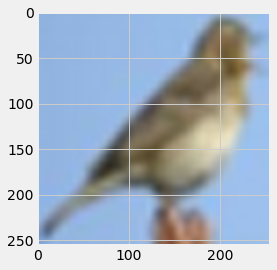

In [229]:
imshow(trainset[0][0])

# Model

In [216]:
# Using pretrained model (relatively small one)
net = torchvision.models.resnet18(pretrained=True, progress=True)

In [217]:
for p in net.parameters():
    p.requires_grad = False

In [218]:
def get_trainable(parameters):
    return (p for p in parameters if p.requires_grad)

In [219]:
net.fc = nn.Linear(512, 10)  # chagning only last layer of a pretrained network (could be more)

## Training on GPU

In [220]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [221]:
# Moving network parameters to device
net.to(device)
# Tensorboard
writer = SummaryWriter('runs/cifar/transfer')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(get_trainable(net.parameters()), lr=0.001)

# batch_size = 4 in trainloader corresponds to ~ 563 MB GPU Memory usage (most of that is model weights)
# with batch_size=4 (10000 iterations * 4 samples = 40000 observations): 30it/s on GPU = 5:20 minutes/epoch compared to 27 minutes/epoch on CPU 

In [222]:
N_EPOCHS = 2
for epoch in range(N_EPOCHS):  
    running_loss = 0.0
    print("Epoch {} / {}".format(epoch + 1, N_EPOCHS))
    for i, (x, y) in enumerate(tqdm(trainloader, leave=False)):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = net(x)
        loss = criterion(y_pred, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            running_loss = 0.0
    # Saving model parameters
    torch.save(net.state_dict(), "states/epoch{}".format(epoch))

Epoch 1 / 2


Epoch 2 / 2


In [223]:
writer.add_graph(net, x)

## Evaluation
It seems that our model learned absolutely nothing. It always predicts class 3 (cat) even though our loss decreased significantly. That means, that maybe features extracted from resnet model (trained on imagenet) are not enough to predict classes in this dataset. This could be true, because this dataset is of low quality and even for people it is difficult to say what is one the image.

In [ ]:
def get_accuracy_and_predictions(data):
    predictions = []
    n = len(data)
    correct = 0
    for tensor, label in tqdm(data, leave=False):
        tensor = tensor.to(device)
        logits = net(tensor.view(-1, 3, 256, 256))
        y_pred = logits.argmax().item()
        predictions.append(y_pred)
        if (y_pred == label):
            correct += 1
    return correct / n, predictions

In [225]:
acc, preds = get_accuracy_and_predictions(testset)
acc, Counter(preds)

(0.1009, Counter({3: 10000}))

In [226]:
classes[3]

'cat'